This project involves classifying emotions from speech audio samples using the RAVDESS dataset. We extract acoustic features (MFCC, Chroma, Mel), apply data augmentation, and compare multiple ML models including Random Forest, XGBoost, LightGBM,SVM and Logisitc Regression.

We define a map for emotion labels and extract file paths and corresponding emotion classes from the RAVDESS dataset folder structure.



In [30]:
# Function to parse RAVDESS folder structure and extract emotion labels and paths
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [2]:
import os 
import pandas as pd

In [3]:
# Define paths to speech and song audio folders
speech_path="Audio_Speech_Actors_01-24"
song_path="Audio_Speech_Actors_01-24"

In [4]:
# Function to parse the RAVDESS dataset folders and extract file paths with emotion labels
def parse_ravdess_folder(base_dir):
    data = []
    for actor in os.listdir(base_dir):
        actor_folder = os.path.join(base_dir, actor)
        if not os.path.isdir(actor_folder):
            continue
        for file in os.listdir(actor_folder):
            if file.endswith(".wav"):
                emotion_code = file.split("-")[2]
                emotion = emotion_map.get(emotion_code)
                if emotion:
                    file_path = os.path.join(actor_folder, file)
                    data.append([file_path, emotion])
    return pd.DataFrame(data, columns=["file_path", "emotion"])

In [5]:
df_speech = parse_ravdess_folder(speech_path)
df_song = parse_ravdess_folder(song_path)

In [6]:
metadata_df = pd.concat([df_speech, df_song], ignore_index=True)

In [7]:
metadata_df.to_csv("metadata.csv", index=False)

In [8]:
print("Parsed", len(metadata_df), "files.")
print(metadata_df.head())

Parsed 2880 files.
                                           file_path  emotion
0  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
1  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
2  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
3  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
4  Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...     calm


In [9]:
import pandas as pd

df = pd.read_csv("metadata.csv")
print(df.head())
print(df['emotion'].value_counts())

                                           file_path  emotion
0  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
1  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
2  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
3  Audio_Speech_Actors_01-24\Actor_01\03-01-01-01...  neutral
4  Audio_Speech_Actors_01-24\Actor_01\03-01-02-01...     calm
emotion
calm         384
happy        384
sad          384
angry        384
fearful      384
disgust      384
surprised    384
neutral      192
Name: count, dtype: int64


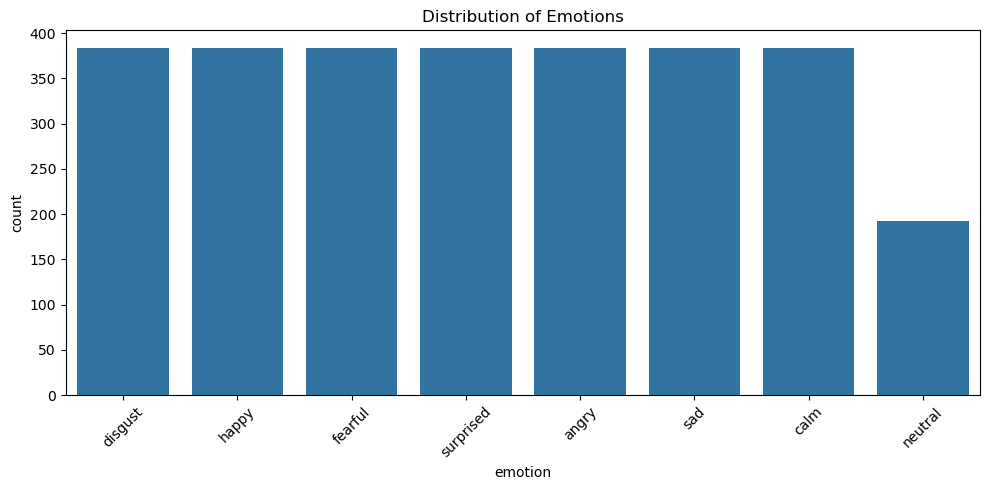

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title("Distribution of Emotions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score,accuracy_score
from xgboost import XGBClassifier
import joblib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


We shuffle the dataset and split it into training and testing sets (80-20 stratified by emotion).

In [11]:
# Shuffle and split
df = df.sample(frac=1, random_state=42)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['emotion'], random_state=42)# Shuffle and split into train and test sets (80/20)

# Shuffle and split into train and test sets (80/20)
X_train, y_train = [], []
X_test, y_test = [], []

We apply four augmentation techniques to increase data variety and robustness:
- Pitch Shifting
- Time Stretching
- Adding Gaussian Noise
- Volume Scaling

In [12]:
#Define Data Augmentation functions
def augment_pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr, n_steps=n_steps)

def augment_time_stretch(y, rate=1.1):
    return librosa.effects.time_stretch(y, rate=rate)

def augment_add_noise(y, noise_factor=0.005):
    noise = np.random.normal(0, noise_factor, y.shape)
    return y + noise

def augment_volume(y, gain_range=(0.8, 1.2)):
    gain = np.random.uniform(*gain_range)
    return y * gain

We then extract significant audio features

In [13]:
#Function to extract audio features
def extract_features(y, sr):
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack((mfcc, chroma, mel))

In [15]:
#Extract features from original audio
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    y, sr = librosa.load(row['file_path'], duration=3, offset=0.5)
    feat = extract_features(y, sr)
    X_train.append(feat)
    y_train.append(row['emotion'])

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    y, sr = librosa.load(row['file_path'], duration=3, offset=0.5)
    feat = extract_features(y, sr)
    X_test.append(feat)
    y_test.append(row['emotion'])

100%|████████████████████████████████████████████████████████████████████████████████| 576/576 [00:29<00:00, 19.73it/s]


In [16]:
#Apply data augmentation on training data
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    y, sr = librosa.load(row['file_path'], duration=3, offset=0.5)
    
    for aug in [augment_pitch_shift, augment_time_stretch, augment_add_noise, augment_volume]:
        try:
            y_aug = aug(y, sr) if 'sr' in aug.__code__.co_varnames else aug(y)
            feat_aug = extract_features(y_aug, sr)
            X_train.append(feat_aug)
            y_train.append(row['emotion'])
        except:
            continue# Skip any failed augmentation cases

100%|██████████████████████████████████████████████████████████████████████████████| 2304/2304 [08:17<00:00,  4.63it/s]


In [17]:
#Encode labels and scale features
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train models

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train_enc)
y_pred_rf = rf.predict(X_test_scaled)

In [19]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train_enc)
y_pred_lr = lr.predict(X_test_scaled)

In [20]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train_enc)
y_pred_svm = svm.predict(X_test_scaled)

In [21]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(X_train_scaled, y_train_enc)
y_pred_lgb = lgb.predict(X_test_scaled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45900
[LightGBM] [Info] Number of data points in the train set: 9644, number of used features: 180
[LightGBM] [Info] Start training from score -2.004741
[LightGBM] [Info] Start training from score -2.026532
[LightGBM] [Info] Start training from score -2.017915
[LightGBM] [Info] Start training from score -2.017135
[LightGBM] [Info] Start training from score -2.012469
[LightGBM] [Info] Start training from score -2.714187
[LightGBM] [Info] Start training from score -2.012469
[LightGBM] [Info] Start training from score -2.010145


In [23]:
model = XGBClassifier(n_estimators=100, learning_rate=0.05, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_scaled, y_train_enc)
y_pred_xgb= model.predict(X_test_scaled)

We use accuracy, classification report, and confusion matrix to compare models.

In [28]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model("Random Forest", y_test_enc, y_pred_rf)
evaluate_model("Logistic Regression", y_test_enc, y_pred_lr)
evaluate_model("SVM", y_test_enc, y_pred_svm)
evaluate_model("LightGBM", y_test_enc, y_pred_lgb)
evaluate_model("XGBoost", y_test_enc, y_pred_xgb)


Random Forest Results
Accuracy: 0.9131944444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.87        76
           1       0.93      0.97      0.95        77
           2       0.86      0.92      0.89        77
           3       0.92      0.90      0.91        77
           4       0.86      0.95      0.90        77
           5       1.00      0.89      0.94        38
           6       0.92      0.90      0.91        77
           7       0.95      0.95      0.95        77

    accuracy                           0.91       576
   macro avg       0.92      0.91      0.91       576
weighted avg       0.92      0.91      0.91       576

Confusion Matrix:
 [[62  2  4  0  4  0  0  4]
 [ 0 75  0  0  0  0  2  0]
 [ 0  0 71  0  6  0  0  0]
 [ 2  2  2 69  0  0  2  0]
 [ 2  0  0  2 73  0  0  0]
 [ 0  0  0  2  0 34  2  0]
 [ 0  2  2  2  2  0 69  0]
 [ 0  0  4  0  0  0  0 73]]

Logistic Regression Results
Accuracy

LightGBM comes out to be the highest performer with the highest accuracy.
It meets all the performance metrics-
1)Accuracy>80%
2)Max F1-score>80%

We compute accuracy for each emotion class based on the confusion matrix of the best performing model (LightGBM).

In [27]:
#Class-wise Accuracy (for best model-LightGBM)
cm = confusion_matrix(y_test_enc, y_pred_lgb)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(class_accuracy):
    print(f"Class {i} accuracy: {acc:.2f}")

Class 0 accuracy: 0.84
Class 1 accuracy: 1.00
Class 2 accuracy: 0.97
Class 3 accuracy: 0.95
Class 4 accuracy: 0.92
Class 5 accuracy: 0.95
Class 6 accuracy: 0.95
Class 7 accuracy: 0.95


Accuracy of each class is greater than 75%

- LightGBM performed best with ~94% accuracy.
- Data augmentation helped in improving generalization.
- Per-class performance shows that all classes are predicted well.


In [35]:
!pip install streamlit

In [42]:
import joblib

# Save model, scaler, and label encoder
joblib.dump(lgb, "lightgbm_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [46]:
# Step: Save the frontend Streamlit code into a .py file
streamlit_code = ""
import streamlit as st
import librosa
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler

# Load model and scaler
model = joblib.load("lightgbm_model.pkl")
scaler = joblib.load("scaler.pkl")

# Feature extraction
def extract_features(y, sr):
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack((mfcc, chroma, mel))

# Emotion labels
emotion_labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Streamlit UI
st.title("Speech Emotion Classifier 🎙️")
uploaded_file = st.file_uploader("Upload a WAV audio file", type="wav")

if uploaded_file is not None:
    st.audio(uploaded_file, format="audio/wav")
    y, sr = librosa.load(uploaded_file, duration=3, offset=0.5)
    features = extract_features(y, sr)
    features_scaled = scaler.transform([features])
    pred = model.predict(features_scaled)
    emotion = emotion_labels[pred[0]]
    st.success(f"Predicted Emotion: **{emotion.upper()}**")
""

with open("streamlit_app.py", "w") as f:
    f.write(streamlit_code)

print("✅ streamlit_app.py file saved successfully.")

✅ streamlit_app.py file saved successfully.


In [38]:
print(os.getcwd())

C:\Users\shamb
